In [1]:
%matplotlib inline
from __future__ import division
from quantecon.stochcp import StochCakeProblem
from quantecon.discretecp import DiscreteCakeProblem
from quantecon.discretecp_additive import DiscreteCakeProblem_additive
from quantecon.compute_fp import compute_fixed_point
from quantecon.tauchen import approx_markov
import matplotlib.pyplot as plt
import numpy as np

#Solving a Cake-Eating Problem using Python

*This work is, in one hand, study notes on the book Economic Dynamics by Jerome Adda and Russel Cooper and, in the other hand, an application of the tools proposed by Quantitative Economics by Thomas Sargent and John Stachurski.  
The code used for solving the problems presented in this document was largely based on the code provided by Quantitative Economics. 
The code snippets shown in this document have been adapted for ease of exposition.  
The full code is available upon request until I figure a way to put it online (basically until I learn to use Github).*  

###Basic Problem
There is a cake of size $W$. You must decide how much cake to eat at each period. Let's say the cake does not spoil.
- Your preferences are represented by: $$ \sum_{t=1}^{T}\beta^{t-1} u(c_t) $$
- At each period you have a cake of size: $$ W_{t+1} = W_{t} - c_t $$
- Evidently, you can't eat more cake than what you currently have: $$ c_t \leq W_{t} $$
- Assume $u(\cdot)$ is differentiable, strictly increasing and strictly concave.  

###Analytical Solution
    
Formulate the problem as trying to maximize your utility: $$ \underset{\{{c_{t}\}_{1}^{T}}} {max} \;\  \sum_{t=1}^{T}\beta^{t-1} u(c_t)  $$
$$ s.t: \;\ W_{1}=W_{T+1}+\sum_{t=1}^{T}c_{t} $$  
$$ given \;\ W_{1} \;\ and \;\ c_t, W_t \geq 0 $$

Lagrange formulation: $$ \underset{\{{c_{t}\}_{1}^{T}} } {max} \;\  
    \mathcal{L} = \sum_{t=1}^{T}\beta^{t-1} u(c_t) + \lambda (W_{1} - W_{T+1} - \sum_{t=1}^{T}c_{t}) $$

First Order Necessary Conditions: $$\frac{\partial\mathcal{L}}{\partial c_{t}}=  \beta^{t-1} u'(c_t) - \lambda = 0 $$  
    $$\frac{\partial\mathcal{L}}{\partial \lambda}=  W_{1} - W_{T+1} - \sum_{t=1}^{T}c_{t} = 0 $$

Which means:
$$\beta^{t-1} u'(c_t) = \lambda $$  
$$ W_{1} - W_{T+1} = \sum_{t=1}^{T}c_{t} $$  
  
We can get the Euler equation by joining the FONC: $$ u'(c_t) = \beta u'(c_{t+1}) $$

In order to understand the necessity of the Euler equation, consider this:  
Imagine you were to eat a lot of cake on the first day and just a little on the rest of the days. As the utility function $u(\cdot)$ is strictly concave, every piece of cake is less satisfying than the one before. So, you would prefer not to eat so much on the first day and eat a little more on the rest of the days.  
If the left-hand side is greater than the right-hand side, it means you are not eating too much cake today and are planning to eat a lot of cake tomorrow. You could get more satisfaction by changing your consumption decision. This also means that the previous decision was not optimal.
  
Satisfying the Euler equation is not enough to ensure you are achieving the maximum. The Euler equation only requires that you can not be better off by switching consumption across periods; but this can be achieved without eating the whole cake. But eating more cake is always better (because $u(\cdot)$ is strictly increasing), so you could satisfy the Euler equation without making an optimal decision.

Let's assume: $$ u(c_t) = \ln(c_t) $$  
Now the Euler equation can be formulated as: $$ \frac{1}{c_t} = \beta \frac{1}{c_{t+1}} $$

And this allows us to express consumption as: $$ c_{t} = \beta^{t-1} c_{1} $$

We can replace the last expression in the constraint: $$ W_{1}=W_{T+1}+\sum_{t=1}^{T}c_{t} $$

Solving for consumption: $$ c_{1} = \frac{W_{1} - W_{T+1}}{\sum_{t=1}^{T}\beta^{t-1}} $$

The optimal solution makes $ W_{T+1} = 0$. (Why?)

Thus the optimal consumption is: $$ c_{t} = \frac{\beta^{t-1}(1 - \beta)}{1 - \beta^{T}} W_{1} $$
  
If $ T \to\infty $: $$ c_{1} = \lim_{T\to\infty}\frac{1 - \beta}{1 - \beta^{T}} W_{1} = (1 - \beta)W_{1} $$

###Dynamic Programming Solution

Let us define a value function as the maximum total utility attainable from a starting cake size: $$ V(W_{1}) = \underset{\{{c_{t}\}_{1}^{\infty}}} {max} \;\ \sum_{t=1}^{\infty}\beta^{t-1} u(c_t)  $$
    $$ s.t. \;\ W_{1}=\sum_{t=1}^{T}c_{t} $$  
We can think of the value function as the answer to the question 'If I were to behave optimally, how much utility would I get from a cake of size $W$?'

We can rewrite the problem as: $$ V(W_{1}) = \underset{c_{1}} {max} \;\ u (c_{1}) + \beta V(W_{1} - c_{1}) $$  
This expression (called the Bellman equation) is pretty intuitive. The problem is being formulated as 'How much do I need to eat today if I know I'll behave optimally tomorrow?'. The maximum total utility you can get from a cake of size W is the utility you get immediately from your optimal consumption plus the (discounted) maximum total utility you can get from the left-over cake.  

The problem can be solved by a method called Value Function Iteration (explained below):
    
1. First, guess a Value Function $V_{k}$
2. Solve the problem (optimize) using $V_{k}$
3. Using the solution, compute the new Value Function $V_{k+1}$
4. Compare $V_{k}$ with $V_{k+1}$ 
5. If the difference is big, start again using $V_{k+1}$. Else, stop.

#####Example

- Consider the problem: $$ V(W_{1}) = \underset{c_{1}} {max} \;\  \log(c_{1}) + \beta V(W_{1} - c_{1}) $$  
- Guess $V_{0} = 0$,for all $W$  
- Maximize $ V_{1}(W) = \underset{c} {max} \;\ \log(c) + \beta V_{0}(W - c) $, for all $W$  
- Since $V_{0} = 0$, then $ V_{1}(W) = \underset{c} {max} \;\ \log(c) $  
- Evidently, $V_{1}(W) = \log(W)$  

- Now, consider the problem: $$ V(W_{1}) = \underset{c_{1}} {max} \;\ log(c_{1}) + \beta V(W_{1} - c_{1}) $$  
- $V_{1}(W) = \log(W)$, for all $W$  
- Maximize $ V_{2}(W) = \underset{c} {max} \;\ log(c) + \beta V_{1}(W - c) $, for all $W$  
- $V_{2}(W) = \beta \log(\beta) - (1+\beta)\log(1+\beta) + (1+\beta)\log W $  
  


###Python Implementation

We write the code for solving this Cake-Eating problem $$ V(W_{1}) = \underset{\{{c_{t}\}_{1}^{\infty}}} {max} \;\ \sum_{t=1}^{\infty}\beta^{t-1} u(c_t)  $$  
$$ W_{t+1} = R( W_{t} - c_t ) $$  
$$ u(c_t) = \frac{c^{1 - \gamma}}{1 - \gamma}, \;\ \gamma \neq 1 $$
$$ u(c_t) = \ln{c_t}, \;\ \gamma = 1 $$

#####Defining the model
```python
    class CakeProblem(object):
        def __init__(self, beta=0.95, r = 1/0.95, gamma = 2, logutil=False,
            grid_max=2, grid_min = .4, grid_size=150):

            self.r, self.beta, self.gamma = r, beta, gamma
            if logutil == False | gamma != 1:
                self.u = lambda c: (c**(1 - gamma))/(1 - gamma)
            else:
                self.u = np.log
                self.gamma = 1
            self.grid = np.linspace(grid_min, grid_max, grid_size)

```
First, we create an object to represent the Cake-Eating problem. This object contains all the parameters necessary for the problem: discount factor **beta**, return rate **r** and the utility function **u**.  
We include a grid for the range of cake sizes. The computer cannot deal with a continuous state space, so we use a grid, a list of points spanning the whole range.

#####Bellman operator
```python
	def bellman_operator(self, w):
		Awx = InterpolatedUnivariateSpline(self.grid, w, k=1)

		Tw = np.empty(len(w))
        for i, x in enumerate(self.grid):
            objective = lambda c: - self.u(c) - self.beta * Awx(self.r*(x - c))
			c_star = fminbound(objective, 1e-6, x-1e-6)
            Tw[i] = - objective(c_star)

        return Tw
```

In a few words, this function takes a discrete value function, does an optimization on it and returns a new value function. 

This function takes as argument **w** which is a list with the same size as the grid which contains a value for each possible cake size. We can think of **w** as a 'discretized' value function.  
If we have to work with a cake size that is not a point of the grid, we can interpolate to calculate its value. The function **Awx** takes as argument a cake size and returns the interpolated value based on the initial discrete value function **w**.

The Bellman operator starts by the very first gridpoint (cake size). It formulates the objective function to be maximized. Then it finds the optimal consumption for the previous function. Finally, it evaluates the optimal consumption in the objective function and stores it in a list; this is the new value for the first gridpoint.  
When the Bellman operator has been applied to every gridpoint, we have a list **Tw**: the new (discretized) value function.

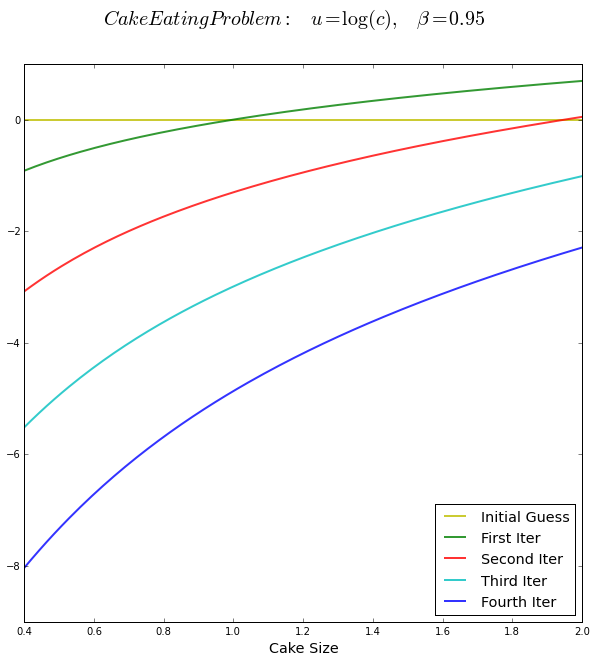

In [2]:
cp = StochCakeProblem(deterministic=True, logutil=True)
v_zero = [np.zeros(len(cp.grid))]*len(cp.shocks)
v_one = cp.bellman_operator(v_zero, compute_policy=False)
v_two = cp.bellman_operator(v_one, compute_policy=False)
v_three = cp.bellman_operator(v_two, compute_policy=False)
v_four = cp.bellman_operator(v_three, compute_policy=False)

fig, ax = plt.subplots(figsize =(10,10))

ax.plot(cp.grid, v_zero[0], 'y-', lw = 2, alpha = .8, label='Initial Guess')
ax.plot(cp.grid, v_one[0], 'g-', lw = 2, alpha = .8, label='First Iter')
ax.plot(cp.grid, v_two[0], 'r-', lw = 2, alpha = .8, label='Second Iter')
ax.plot(cp.grid, v_three[0], 'c-', lw = 2, alpha = .8, label='Third Iter')
ax.plot(cp.grid, v_four[0], 'b-', lw = 2, alpha = .8, label='Fourth Iter')
ax.legend(loc = 'lower right', fontsize='x-large')
ax.set_xlabel("Cake Size", fontsize='x-large')

t = r'$Cake Eating Problem:\;\ u = \log(c), \;\ \beta = {0:.2f}$'.format(cp.beta)
fig.suptitle(t, fontsize=20)

plt.show()

#####Solving the problem
If we were to apply the Bellman operator on the true value function, the result should be the true value function. This means the true value function is a fixed point of the Bellman operator. We also know, because of the contraction mapping theorem and Blackwell's sufficient conditions for a contraction*, that if we start with any value function and apply the Bellman operator repeatedly, we will approach the true value function.

*[Stokey, N., & Lucas, R. with E. Prescott (1989): Recursive Methods in Economic Dynamics.](http://www.amazon.com/Recursive-Methods-Economic-Dynamics-Stokey/dp/0674750969) pp. 49/55  

The following code is taken from [*Quantitative Economics by John Stachurski and Thomas J. Sargent.*](quant-econ.net)

```python
    def compute_fixed_point(T, v, error_tol=1e-3, max_iter=50,
                            print_skip=5, *args, **kwargs):
        iterate = 0
        error = error_tol + 1

        while iterate < max_iter and error > error_tol:
            new_v = T(v, *args, **kwargs)
            iterate += 1
            error = np.max(np.abs(new_v - v))

            try:
                v[:] = new_v
            except TypeError:
                v = new_v
        return v
```

This function takes as argument the Bellman operator **T** and an initial value function **v**. It applies the Bellman operator for a number of times or until the difference between the value functions is very low. The number of times it can run and the difference tolerance can be adjusted in the arguments **error_tol** and **max_iter**.

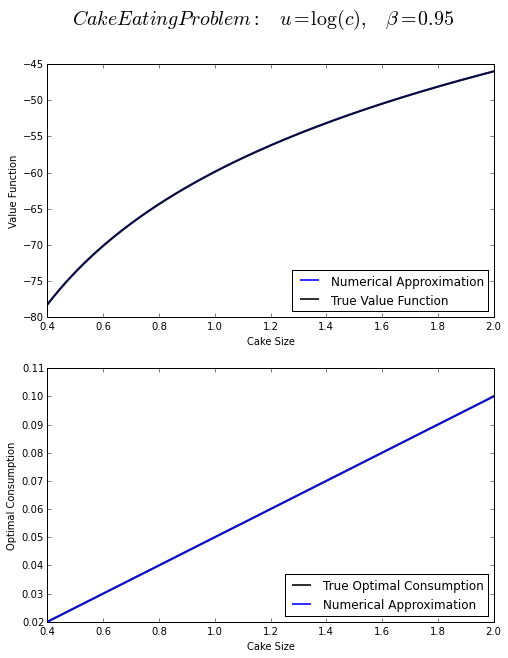

In [3]:
cp = StochCakeProblem(logutil=True, deterministic=True)
fig, ax = plt.subplots(2, 1, figsize =(8,10))

b = (1/(1-cp.beta))
a = b*np.log(1-cp.beta)+b*b*cp.beta*np.log(cp.r*cp.beta)
true_v = a + b*np.log(cp.grid) # True Value Function
true_sigma = (1 - cp.beta)*cp.grid # True Policy Function
v = [10 + 15*np.log(cp.grid)]*len(cp.shocks) # Value Function Guess
v_star = compute_fixed_point(cp.bellman_operator, v, max_iter = 500, verbose = 0) #Numerical Approximation
sigma = cp.compute_greedy(v_star) #Numerical Approximation

ax[0].set_xlabel("Cake Size")
ax[1].set_xlabel("Cake Size")
ax[0].set_ylabel("Value Function")
ax[1].set_ylabel("Optimal Consumption")
ld = 'Numerical Approximation'

ax[0].plot(cp.grid, v_star[0], 'b-', lw = 2, alpha = .8, label = ld)
ax[0].plot(cp.grid, true_v, 'k-', lw = 2, alpha = .8, label='True Value Function')
ax[1].plot(cp.grid, true_sigma, 'k-', lw = 2, alpha = .8, label='True Optimal Consumption')
ax[1].plot(cp.grid, sigma[0], 'b-', lw = 2, alpha = .8, label = ld)
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

t = r'$Cake Eating Problem:\;\ u = \log(c), \;\ \beta = {0:.2f}$'.format(cp.beta)
fig.suptitle(t, fontsize=20)

plt.show()

We can appreciate that the numerical approximation is good, although the left-end is a little problematic when we don't cover
for cake sizes close to zero.

###Extensions

####Stochastic case
Consider a modification to the original problem. Each period after you have eaten your portion of cake you receive an additional piece of cake. However, the exact amount of extra cake you will receive is random.  
We rewrite the problem as: $$ V(W_{1}) = \underset{\{{c_{t}\}_{1}^{\infty}}} {max} \;\ \sum_{t=1}^{\infty}\beta^{t-1} u(c_t)  $$  
$$ W_{t+1} = R( W_{t} - c_t) + y' $$  
The Bellman equation would be:  
$$ V(W) = \underset{c} {max} \;\  u(c) + \beta \underset{y' | y} E[V( R( W - c) + y'] $$

#####Python Implementation
We need to include a new set of specifications in order to deal with the stochastic case. A simple (but useful) way of dealing with the stochastic extension is using Markov Chains: $$\begin{bmatrix}
    \pi_{ll} & \pi_{lh} \\
    \pi_{lh} & \pi_{hh} 
\end{bmatrix}$$

As we'll see below, this formulation will allow us to easily  approximate an AR(1) process.

```python
    class CakeProblem(object):
        def __init__(self, beta=0.95, r = 1/0.95, gamma = 2, logutil=False, shocks = [.9, 1.1],
                     transition = [[.5,.5],[.5,.5]], deterministic=False, grid_max=2,
                     grid_min = .4, grid_size=150):

            self.r, self.beta, self.gamma = r, beta, gamma
            self.shocks = shocks
            self.transition = np.asarray(transition)
            self.deterministic = deterministic

            if deterministic == True:
                self.transition = np.asarray([[1]])
                self.shocks = np.asarray([0])

            if logutil == False:
                self.u = lambda c: (c**(1 - gamma))/(1 - gamma)
            else:
                self.u = np.log
                self.gamma = 1
            self.grid = np.linspace(grid_min, grid_max, grid_size)


        def bellman_operator(self, w):
            Aw = [InterpolatedUnivariateSpline(self.grid, w[i], k=3) for i in xrange(len(self.shocks))]
            Awx = lambda y : [Aw[i](y[i]) for i in xrange(len(y))]

            Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))

                for i, x in enumerate(self.grid):
                    for j in xrange(len(self.shocks)):
                        objective = lambda c: - self.u(c) - self.beta*(np.dot(self.transition[j],
                                                                Awx(np.add(self.r*(x - c), self.shocks))))
                        c_star = fminbound(objective, 1e-6, x-1e-6)

                        Tw[j][i] = - objective(c_star)

                return Tw

```
The main difference is that we now take a shock list and a transition matrix as specification for the Cake Problem. Also, the objective function now takes into account the expectation of the next period value function (*np.dot(...)* is a conditional expectation because *self.transition[j]* is a probability distribution).


##### Example:
**(Adda & Cooper - 2003) Figure 3.2** Suppose that the stochastic endowment of cake has two possible values: $ 0.9 $ and $1.1 $. Assume a CRRA utility function with $\gamma = 2$, discount factor $ \beta = .95$ and an unconditional probability of a high endowment of $.5$. Plot the value function and the optimal consumption as a function of the cake size.

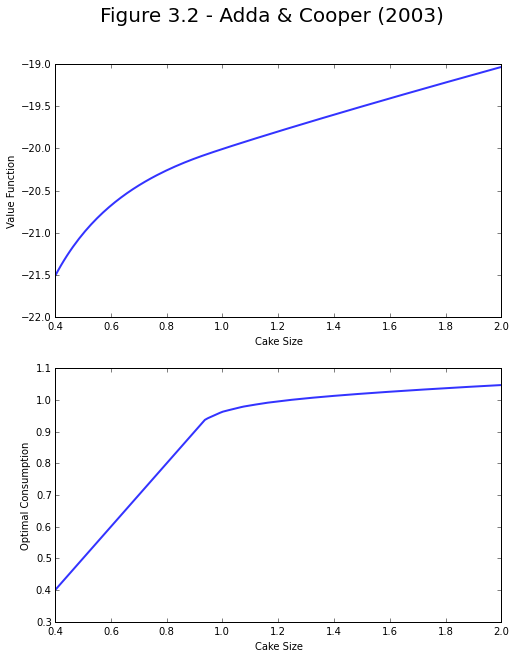

In [4]:
scp2 = StochCakeProblem(gamma=2, shocks=[.9, 1.1], transition=[[.5, .5],[.5, .5]])

fig, ax = plt.subplots(2, 1, figsize =(8,10))

v = np.asarray([np.zeros(scp2.grid.size)]*len(scp2.shocks))
v_star = compute_fixed_point(scp2.bellman_operator, v, max_iter = 500, verbose = 0)
sigma = scp2.compute_greedy(v_star)

ax[0].set_xlabel("Cake Size")
ax[1].set_xlabel("Cake Size")
ax[0].set_ylabel("Value Function")
ax[1].set_ylabel("Optimal Consumption")

ax[0].plot(scp2.grid, v_star[0], 'b-', lw = 2, alpha = .8)
ax[1].plot(scp2.grid, sigma[0], 'b-', lw = 2, alpha = .8)

t = r'Figure 3.2 - Adda & Cooper (2003)'
fig.suptitle(t, fontsize=20)

plt.show()

It is interesting to note how the optimal policy for small cakes is to eat all of it. By small, I mean in comparison to the stochastic endowments. For very small cakes it makes sense to eat all of it because you will get the same amount of (or more) cake tomorrow.  
As the cake grows, diminishing returns kick in and the optimal policy is to start saving.
This can be easily checked by playing with the parameters of the stochastic endowments.


**(Adda & Cooper - 2003) Exercise 3.1.** Suppose that $ u(c) = {c^{(1 - \gamma)}}/{1 -\gamma}$. Construct the code to solve for the stochastic cake-eating problem using the value function iteration method. Plot the policy function as a function of the size of the cake and the stochastic endowment for $\gamma = \{ 0.5, \;\ 1.2\}$. Compare the level and slope of the policy functions for different values of $\gamma$. How do you interpret the results?



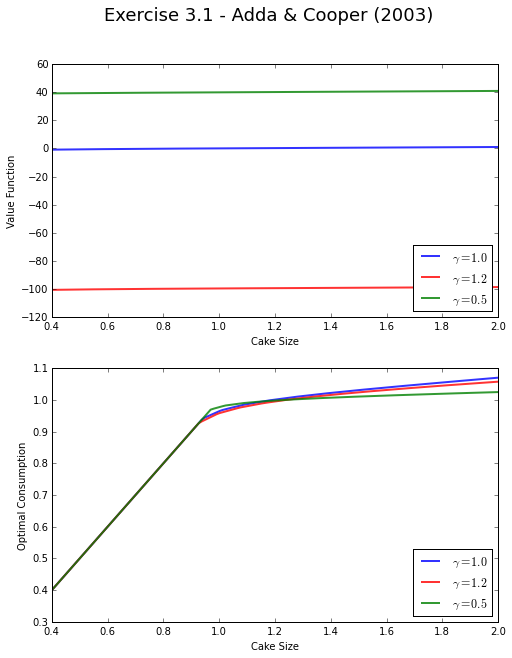

In [5]:
scp = StochCakeProblem(logutil=True, shocks=[.9, 1.1], transition=[[.5, .5],[.5, .5]])
w_guess = np.asarray([np.log(scp.grid)]*len(scp.shocks))
w_star = compute_fixed_point(scp.bellman_operator, w_guess, max_iter=100, verbose=0)
sigma = scp.compute_greedy(w_star)
l = r'$\gamma = {0:.1f}$'.format(scp.gamma)

scp12 = StochCakeProblem(gamma=1.2, shocks=[.9, 1.1], transition=[[.5, .5],[.5, .5]])
w12_guess = np.asarray([np.log(scp12.grid)]*len(scp12.shocks))
w12_star = compute_fixed_point(scp12.bellman_operator, w12_guess, max_iter=100, verbose=0)
sigma12 = scp.compute_greedy(w12_star)
l12 = r'$\gamma = {0:.1f}$'.format(scp12.gamma)

scp5 = StochCakeProblem(gamma=.5,  shocks=[.9, 1.1], transition=[[.5, .5],[.5, .5]])
w5_guess = np.asarray([np.log(scp5.grid)]*len(scp5.shocks))
w5_star = compute_fixed_point(scp5.bellman_operator, w5_guess, max_iter=100, verbose=0)
sigma5 = scp.compute_greedy(w5_star)
l5 = r'$\gamma = {0:.1f}$'.format(scp5.gamma)

fig, ax = plt.subplots(2, 1, figsize =(8,10))

ax[0].set_xlabel("Cake Size")
ax[1].set_xlabel("Cake Size")
ax[0].set_ylabel("Value Function")
ax[1].set_ylabel("Optimal Consumption")

ax[0].plot(scp.grid, w_star[0], 'b-', lw = 2, alpha = .8, label = l)
ax[0].plot(scp12.grid, w12_star[0], 'r-', lw = 2, alpha = .8, label = l12)
ax[0].plot(scp5.grid, w5_star[0], 'g-', lw = 2, alpha = .8, label = l5)
ax[1].plot(scp.grid, sigma[0], 'b-', lw = 2, alpha = .8, label = l)
ax[1].plot(scp12.grid, sigma12[0], 'r-', lw = 2, alpha = .8, label = l12)
ax[1].plot(scp5.grid, sigma5[0], 'g-', lw = 2, alpha = .8, label = l5)
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

t = r'Exercise 3.1 - Adda & Cooper (2003)'
fig.suptitle(t, fontsize=18)

plt.show()

The main difference is due to the elasticity of substitution. When $\gamma$ is low, the elasticity of substitution (how willing you are to have a highly variable consumption path) is higher.

####Functional discount factor
Consider that the discount factor is a function of the level of consumption $\beta(c)$.

#####Python Implementation
```python 
    class CakeProblem(object):
        def __init__(self, beta=0.95, r = 1/0.95, gamma = 2, logutil=False, functional=False,
				 shocks = [.9, 1.1], transition = [[.5,.5],[.5,.5]], deterministic=False, grid_max=2,
				 grid_min = .4, grid_size=150):
            (...)
            if functional == True:
                self.beta = lambda c: norm.cdf(1.65 - c) 
            (...)
       
        def bellman_operator(self, w):
            (...)
            for i, x in enumerate(self.grid):
                for j, e in xrange(len(self.shocks)):
                    objective = lambda c: -self.u(c) -self.beta(c)*(np.dot(self.transition[j],
                                                                Awx(np.add(self.r*(x - c), self.shocks))))
                    c_star = fminbound(objective, 1e-6, x-1e-6)
                    
                    Tw[j][i] = - objective(c_star)
            (...)
```
In case we want to use a functional discount factor, we must specify the functional form for it. In the objective function, the only difference is to include the current level of consumption as argument for **self.beta**.

**(Adda & Cooper - 2003) Exercise 3.4.** Consider the stochastic cake-eating problem. Suppose that the discount rate $\beta$ is a function of the amount of cake consumed: $\beta = \Phi(\beta_{1} + \beta_{2}c)$, where $\beta_{1}$ and $\beta_{2}$ are known parameters and $\Phi$ is the normal cumulative distribution function. Construct thecode to solve for this new problem using value function iterations. Suppose $ \gamma = 2$, $\beta_{1} = 1.65$, $\pi_{L} = \pi_{H} = 0.5 $, $y_{L} = .8 $, $y_{H} = 1.2$ and $ \beta_{2} = -1 $. Plot the policy rule $c = c(X)$. Compare the result with that of the case where the discount rate is independent of the quantity consumed. How would you interpret the fact that the discount rate depends on the amount of cake consumed?


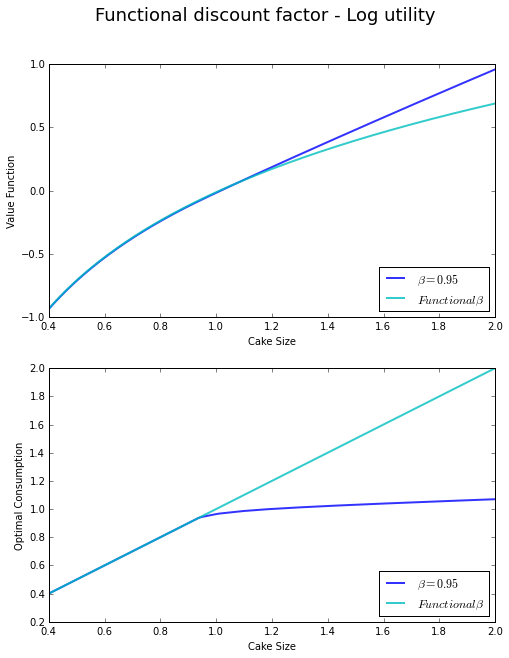

In [6]:
scp = StochCakeProblem(logutil=True, shocks=[.9, 1.1], transition=[[.5, .5],[.5, .5]])
w_guess = np.asarray([np.log(scp.grid)]*len(scp.shocks))
w_star = compute_fixed_point(scp.bellman_operator, w_guess, max_iter=100, verbose=0)
sigma = scp.compute_greedy(w_star)
l = r'$\beta = {0:.2f}$'.format(scp.beta)

fcp = StochCakeProblem(functional=True, logutil=True)
v_guess = np.asarray([np.log(scp.grid)]*len(fcp.shocks))
v_star = compute_fixed_point(fcp.bellman_operator, v_guess, max_iter = 500, verbose = 0)
sigma_f = fcp.compute_greedy(v_star)
lf = r'$Functional \beta$'

fig, ax = plt.subplots(2, 1, figsize =(8,10))
ax[0].set_xlabel("Cake Size")
ax[1].set_xlabel("Cake Size")
ax[0].set_ylabel("Value Function")
ax[1].set_ylabel("Optimal Consumption")

ax[0].plot(scp.grid, w_star[0], 'b-', lw = 2, alpha = .8, label = l)
ax[0].plot(fcp.grid, v_star[0], 'c-', lw = 2, alpha = .8, label = lf)
ax[1].plot(scp.grid, sigma[0], 'b-', lw = 2, alpha = .8, label = l)
ax[1].plot(fcp.grid, sigma_f[0], 'c-', lw = 2, alpha = .8, label = lf)
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

t = 'Functional discount factor - Log utility'
fig.suptitle(t, fontsize=18)

plt.show()

The functional form used here is $\beta = \Phi(1.65 - c)$, where norm is the normal cumulative distribution.
This gives a negative relationship between the discount factor and the level of consumption.
Therefore, a higher level of consumption makes the agent less future-oriented and more willing to consume now.
In this particular case, this effect is so large, it is optimal to eat all the cake, every time.
(Changing the functional form of $\beta$ could change its results. For instance,
$\beta=\Phi(1.95 - c/30)$

####Discrete Choice
Now, you have to decide whether to eat the whole cake now or wait until you are hungrier.
$$ \underset{\{{E}, {W}\}} {max} \;\  V(W, \;\ \large{\epsilon})  $$
Where $V$ is the Value Function, satisfying the Bellman equation: $$ V(W, \;\  \large{\epsilon}) = max\{\large{\epsilon}  u(W), \;\  \beta \underset{\large{\epsilon}{\small{'}} | \large{\epsilon}} E[V(\rho W, \;\ \large{\epsilon}')]\} $$
Where $\large \epsilon$ is a taste shock.
#####Python Implementation
```python
   def bellman_operator(self, w):
        Aw = [InterpolatedUnivariateSpline(self.grid, w[i], k=3) for i in xrange(len(self.shocks))]
		Awx = lambda y: np.asarray([function(y) for function in Aw])
		
        for i, x in enumerate(self.grid):
			for j, e in enumerate(self.shocks):
				u_now = e*self.u(x)
				u_wait  = self.beta*np.dot(self.transition[j], Awx(self.r*x))
				Tw[j][i] = max(u_now, u_wait)

        return Tw
```
It's a simpler problem, the Bellman operator only needs to compare among the two possible options.

##### Example: 
**(Adda & Cooper - 2003) Exercise 3.3.** Consider, again, the discrete cake-eating problem of section 3.3. Construct the code to solve for this problem, with iid taste shocks, using $  u(c) = \ln(c), \;\ \large \epsilon_{L} = 0.8,  \;\ \epsilon_{H} = 1.2,  \;\ \pi_{L} = 0.3,  \;\ \pi_{H} = 0.7 $. Map the decision rule as a function of the size of the cake.


CakeEatingModel:
  - beta (discount factor)                             : 0.95
  - r (shrink factor)                                  : 0.95
  - u (utility function)                               : <ufunc 'log'>
  - grid bounds (bounds for grid over savings values)  : (1.0, 4.0)
  - grid points (number of points in grid for savings) : 150



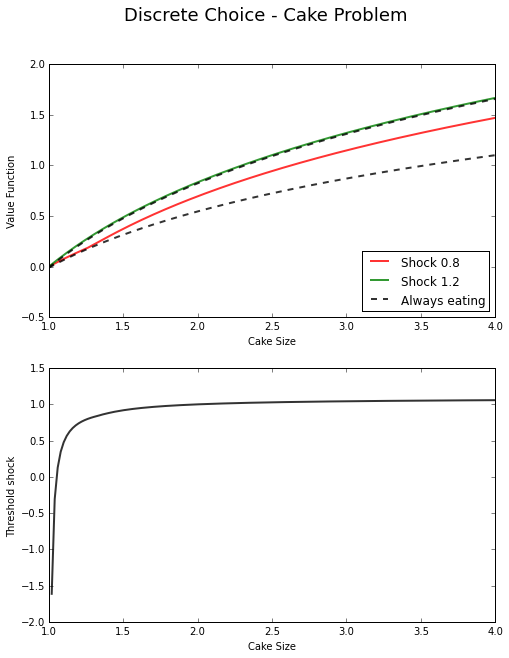

In [7]:
# Transition matrix for shocks
trans = [[3, 7], 
         [3, 7]]
# List of Taste Shocks 
shocklist= [.8, 1.2] 
# Discount rate
discount = .95 
# Shrink rate for the cake. X_{t+1} = shrink_rate*X_{t}
shrink_rate = .95

# Specifying the range of values for the cake size
gmin = 1
gmax = 4
#gsize = 150

# Instantiating the Cake Problem
cp = DiscreteCakeProblem(logutil=True, transition=trans, grid_min=gmin, grid_max=gmax, #grid_size=gsize,
                          shocks=shocklist, r=shrink_rate, beta=discount)
# Plotting
cp.plot()

The area under the black curve is the set of cake size and taste shock for which waiting is optimal.
The dashed line in the first figure represents the utility obtained if the cake is eaten instead of waiting. Therefore, if the colored line is above the dashed line, the optimal decision is waiting.
We can appreciate that the optimal decision when facing a low taste shock changes from eating to waiting when the cake size is bigger than ~1.4.

**Example 2.** Four possible taste shocks. Arbitrary transition matrix.

CakeEatingModel:
  - beta (discount factor)                             : 0.95
  - r (shrink factor)                                  : 0.95
  - u (utility function)                               : <ufunc 'log'>
  - grid bounds (bounds for grid over savings values)  : (1.0, 30.0)
  - grid points (number of points in grid for savings) : 150



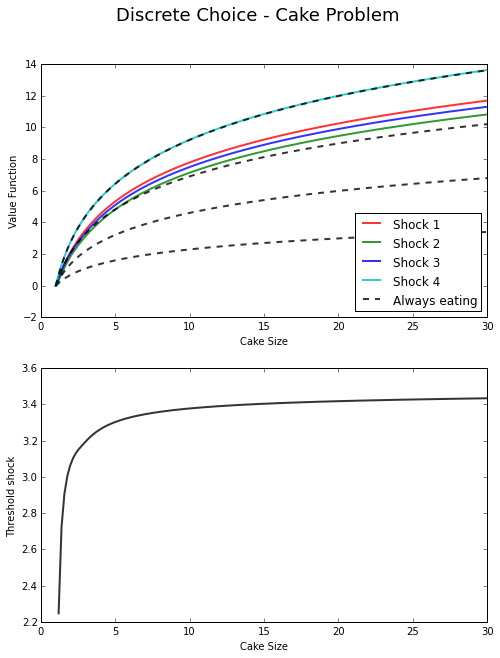

In [8]:
# Transition matrix for shocks
trans = [[1, 2, 4, 8], 
         [2, 2, 3, 1],
         [0, 3, 3, 4],
         [1, 1, 1, 1]] 
# List of Taste Shocks 
shocklist= [1, 2, 3, 4] 
# Discount rate
discount = .95 
# Shrink rate for the cake. X_{t+1} = shrink_rate*X_{t}
shrink_rate = .95

# Specifying the range of values for the cake size
gmin = 1
gmax = 30
#gsize = 150

# Instantiating the Cake Problem
cp = DiscreteCakeProblem(logutil=True, transition=trans, grid_min=gmin, grid_max=gmax, #grid_size=gsize,
                          shocks=shocklist, r=shrink_rate, beta=discount)
# Plotting
cp.plot()

Surprisingly, the Value Function for the lowest taste shock is higher than most other taste shocks. The reason for this lies in the transition matrix; having the lowest taste shock is also a signal of a very likely high taste shock later.

The second figure is not very helpful. Its conclusions based on the idea of the probability distribution being 'somewhat' continuous on the taste shock value. The arbitrary transition matrix of this example is not continuous.

**(Adda & Cooper - 2003) Figure 3.7 and Figure 3.8.** Consider the following utility function $u(X, \nu) = \ln(\nu X)$. Where $\ln(\nu)$ follows an AR(1) process. Construct the code to solve this problem. Plot the value function and the policy function for $\beta = .95$, $\rho = .95$; the taste shocks follow an AR(1) process with autocorrelation $ 0.5 $ and unconditional variance of $0.2$.  

$$ V(X, \;\  {\nu}) = max\{ u(X, \nu), \;\  \beta \underset{{\nu}\large{'} | {\nu}} E[V(\rho X, \;\ {\nu}')]\} $$
$$ \large{\nu_{t} = \rho \nu_{t-1} + \epsilon} , \;\ \large{\epsilon} \sim \mathcal{N}(0, 1)$$

We can approximate an AR(1) process using a first order Markov Chain following Tauchen's method. The following code is from [*Quantitative Economics by John Stachurski and Thomas J. Sargent.*](www.quant-econ.net))

```python
    def approx_markov(rho, sigma_u, m=3, n=7):
        F = norm(loc=0, scale=sigma_u).cdf

        # standard deviation of y_t
        std_y = np.sqrt(sigma_u**2 / (1-rho**2))
        # top of discrete state space
        x_max = m * std_y
        # bottom of discrete state space
        x_min = - x_max
        # discretized state space
        x = np.linspace(x_min, x_max, n)

        step = (x_max - x_min) / (n - 1)
        half_step = 0.5 * step
        P = np.empty((n, n))

        for i in range(n):
            P[i, 0] = F(x[0]-rho * x[i] + half_step)
            P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
            for j in range(1, n-1):
                z = x[j] - rho * x[i]
                P[i, j] = F(z + half_step) - F(z - half_step)

        return x, P
```
Basically, Tauchen's method discretizes a large part of the space in a finite number of intervals. It generates one point per interval and assigns to it the value of the (weighted) average of the possible values of the interval. It also assigns a probability to each of these points equivalent to the probability of a random variable falling in its own interval.

CakeEatingModel:
  - beta (discount factor)                             : 0.95
  - r (shrink factor)                                  : 0.95
  - u (utility function)                               : <ufunc 'log'>
  - grid bounds (bounds for grid over savings values)  : (0.5, 10.0)
  - grid points (number of points in grid for savings) : 150



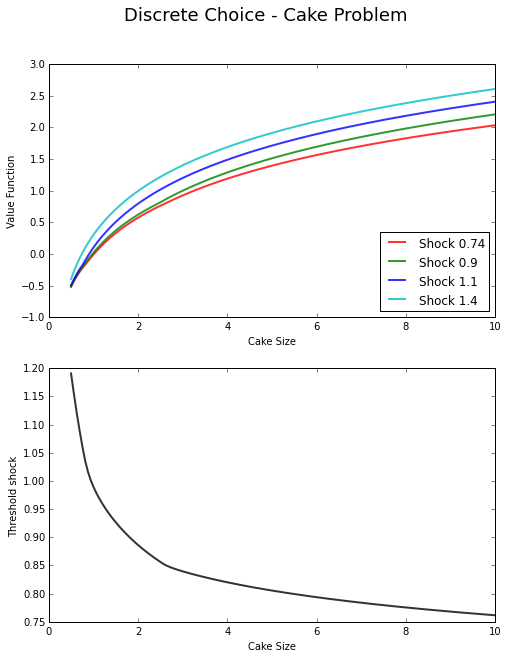

In [9]:
# Using Tauchen method for approximating an AR(1) process using a first order Markov Chain
epsilon, trans = approx_markov(rho = .5, sigma_u=.2, n = 4, m=1.3)
shocklist = np.exp(epsilon)
discount = .95 # Discount rate
shrink_rate = .95 # Shrink rate for the cake. X_{t+1} = shrink_rate*X_{t}

# Specifying the range of values for the cake size
gmin = .5
gmax = 10

# Instantiating the Cake Problem - Additive
cp = DiscreteCakeProblem_additive(logutil=True, transition=trans, grid_min=gmin, grid_max=gmax, 
                          shocks=shocklist, r=shrink_rate, beta=discount)
cp.plot()

###References

[Adda, J., & Cooper, R. W. (2003). Dynamic economics: quantitative methods and applications. MIT press.](http://www.amazon.com/Dynamic-Economics-Quantitative-Methods-Applications/dp/0262012014)

[Stokey, N., & Lucas, R. with E. Prescott (1989): Recursive Methods in Economic Dynamics.](http://www.amazon.com/Recursive-Methods-Economic-Dynamics-Stokey/dp/0674750969)

[**Quantitative Economics by John Stachurski and Thomas J. Sargent.**](www.quant-econ.net)